In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
#from sklearn.impute import KNNImputer
#from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Making notna() recognize also empty strings and numpy.inf
pd.options.mode.use_inf_as_na = True

## Loading the Data and Exploring

In [2]:
train = pd.read_csv("./train.csv")
store = pd.read_csv("./store.csv")

C:\Users\grott\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Check missing values in train
train.isnull().sum() / train.shape[0]

Date             0.000000
Store            0.030263
DayOfWeek        0.029818
Sales            0.029833
Customers        0.029934
Open             0.030083
Promo            0.030095
StateHoliday     0.030189
SchoolHoliday    0.030320
dtype: float64

In [4]:
# Remove stores with no IDs since predictions will be based on stores
train.dropna(axis=0, inplace=True, subset=["Store", "Sales"])

In [5]:
# Check for missing values in stores table
store.isnull().sum() / store.shape[0]

Store                        0.000000
StoreType                    0.000000
Assortment                   0.000000
CompetitionDistance          0.002691
CompetitionOpenSinceMonth    0.317489
CompetitionOpenSinceYear     0.317489
Promo2                       0.000000
Promo2SinceWeek              0.487892
Promo2SinceYear              0.487892
PromoInterval                0.487892
dtype: float64

In [6]:
# Joining datasets together
dataset = train.join(store.set_index("Store"), on="Store").reset_index(drop=True)

In [7]:
# Inspecting nulls after joining
dataset.isnull().sum() / dataset.shape[0]

Date                         0.000000
Store                        0.000000
DayOfWeek                    0.029825
Sales                        0.000000
Customers                    0.029939
Open                         0.030144
Promo                        0.030315
StateHoliday                 0.030072
SchoolHoliday                0.030380
StoreType                    0.000000
Assortment                   0.000000
CompetitionDistance          0.002632
CompetitionOpenSinceMonth    0.317665
CompetitionOpenSinceYear     0.317665
Promo2                       0.000000
Promo2SinceWeek              0.490795
Promo2SinceYear              0.490795
PromoInterval                0.490795
dtype: float64

In [8]:
# Replacing DayOfWeek with proper data based on Date column
dataset = dataset.astype({"Date": "datetime64[ns]"})
dataset["DayOfWeek"] = dataset["Date"].dt.weekday

In [9]:
# Removing rows with many nulls
nans_to_drop =["DayOfWeek", "Customers", "Open", "Promo", 
                "StateHoliday", "SchoolHoliday","CompetitionOpenSinceMonth", 
                "CompetitionOpenSinceYear", "Promo2SinceWeek", "Promo2SinceYear", 
                "PromoInterval"]
dataset.dropna(axis=0, inplace=True, subset=nans_to_drop)

In [10]:
# Drop rows with no sales
dataset = dataset.loc[(dataset["Sales"] != 0)]

#df = pd.DataFrame({"A":[0,1,2], "B": [4,5,0] })
#df.loc[(df["A"] != 0)]

In [11]:
# OBSOLETE

# Checking other NAs and what to do
# dataset["DayOfWeek"].unique()

# DayofWeek has nans nas could be filled throug date column --> easier could be derived from it and original dropped --> DONE
# Open fill nas through date if ir is not a Sunday
# Sales Impute --> DONE
# Customers can be imputed (but clarify if we need it) --> DONE
# Promo replace NAs with "no promotion" --> DONE
# StateHoliday data has different data types for same values
# SchoolHoliday can be filled based on actual but could be dropped since likely irrelevant


In [12]:
# OBSOLETE

# Replacing DayOfWeek with the correct number
# dataset = dataset.astype({"Date": "datetime64[ns]"})
# dataset["DayOfWeek"] = dataset["Date"].dt.weekday

# Checking what weekdays are there when NAs for Open
# dataset[dataset["Open"].isnull()]["DayOfWeek"].unique()

# Put correct data types
#dataset = dataset.astype({"Date": "datetime64[ns]", "Store": int, "Customers": int})

#### Adjusting Datatypes

In [13]:
dataset.dtypes

Date                         datetime64[ns]
Store                               float64
DayOfWeek                             int64
Sales                               float64
Customers                           float64
Open                                float64
Promo                               float64
StateHoliday                         object
SchoolHoliday                       float64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
dtype: object

In [14]:
col_types = {"Date": "datetime64[ns]", "DayOfWeek": int, "Store": int, "Customers": int, 
             "Open": int, "Promo": int, "SchoolHoliday": str, "CompetitionOpenSinceMonth": int,
             "CompetitionOpenSinceYear": int, "Promo2SinceWeek": int, "Promo2SinceYear": int}
dataset = dataset.astype(col_types, copy=False)

## Encoding

In [15]:
# Target Encoding for Store
ce_te = ce.TargetEncoder(cols=["Store"])

# Setting on customers first
ce_te.fit(dataset["Store"], dataset["Customers"])
dataset["Store_tgt_enc"] = ce_te.transform(dataset["Store"])

# Target Encoding for DayOfWeek
ce_te = ce.TargetEncoder(cols=["DayOfWeek"])
ce_te.fit(dataset["DayOfWeek"], dataset["Customers"])
dataset["DayOfWeek_tgt_enc"] = ce_te.transform(dataset["DayOfWeek"])

# Below code not applied because FE did not yield high correlation to target after all

# Frequency Encoding
# ce_fe = dataset.groupby("Store").size()
# ce_fe = ce_fe / len(dataset)
# dataset["Store_frq_enc"] = dataset["Store"].map(ce_fe)

# dataset.drop(axis=1, labels=["Store_frq_enc"], inplace=True)



<AxesSubplot:>

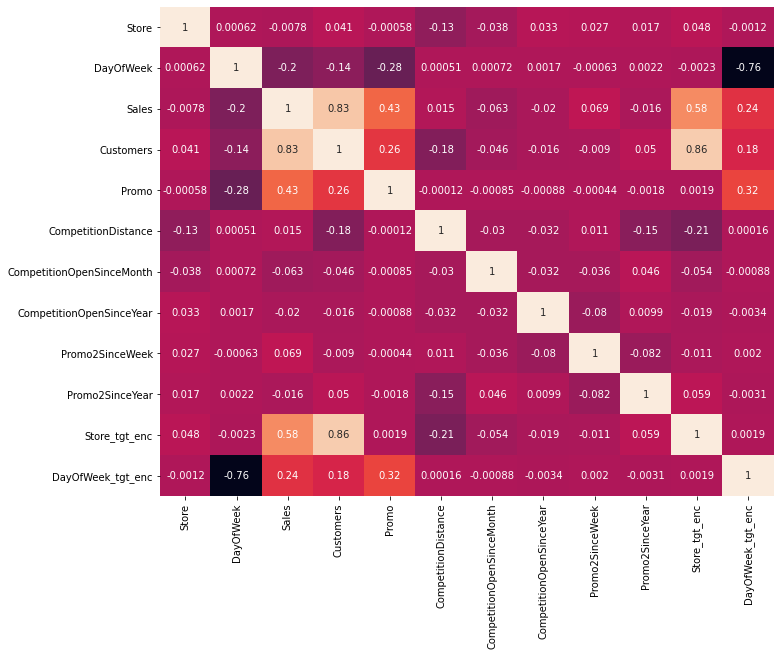

In [30]:
# Check correlations
plt.subplots(figsize=(11,9))
cols_to_exl = ["Open", "Promo2"]
sns.heatmap(dataset.drop(cols_to_exl, axis=1).corr(), cbar=False, annot=True)

In [31]:
# Resetting index
dataset.reset_index(drop=True, inplace=True)

## Test / Train Split

In [32]:
x = dataset.loc[:, (dataset.columns != "Sales")]
y = dataset["Sales"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=None, shuffle=False)

### Imputing Target and Other Columns

In [19]:
# OBSOLETE

# Imputing Target
#knn_imputer = KNNImputer(weights="distance")
#y_train = knn_imputer.fit_transform(np.array(y_train).reshape(-1,1))

# Imputing "Customers"
#x_train["Customers"] = knn_imputer.fit_transform(np.array(x_train["Customers"]).reshape(-1,1))

# Imputing "Open" for Sunday to be closed
#sunday_open_nan = (x_train["Open"].isnull()) & (dataset["DayOfWeek"] == 6)
#x_train.loc[sunday_open_nan, "Open"] = 0
# Imputing "Open" remaining with most_frequent
#simple_imputer = SimpleImputer(strategy="most_frequent")
#x_train["Open"] = simple_imputer.fit_transform(np.array(x_train["Open"]).reshape(-1,1))

# Imputing "Promo" for Sunday to be 0
#promo_sunday_nan = (x_train["Promo"].isnull()) & (x_train["DayOfWeek"] == 6)
#x_train.loc[promo_sunday_nan, "Promo"] = 0
# Imputing "Promo" with most_frequent
#x_train["Promo"] = simple_imputer.fit_transform(np.array(x_train["Promo"]).reshape(-1,1))

## Fit and Predict

In [33]:
def metric(preds, actuals):
    #preds = preds.reshape(-1)
    #actuals = actuals.reshape(-1)
    assert preds.shape == actuals.shape
    # return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])
    return 100 * (np.sqrt(np.mean(np.square((actuals - preds) / actuals))))

#### Baseline Model

In [52]:
# Using mean as Baseline
y_pred = np.array([y_train.mean() for _ in range(y_test.shape[0])])
print(f"Baseline yield {metric(y_pred, y_test):.2f}% RMSPE as error")


Baseline yield 55.03% RMSPE as error


In [35]:
features = ["Customers", "Promo", "DayOfWeek_tgt_enc", "Store_tgt_enc"]

rfr = RandomForestRegressor(max_depth=20, n_estimators=50)
rfr.fit(x_train[features], y_train)
y_pred = rfr.predict(x_test[features])

print(f"Random Forest Regresor with features {features} yield {metric(y_test, y_pred):.2f}% as error")

Random Forest Regresor with features ['Customers', 'Promo', 'DayOfWeek_tgt_enc', 'Store_tgt_enc'] yield 9.89% as error


## Cross-Validation for Overfitting Check

In [36]:
# With cross_val_score
rfr_cv = RandomForestRegressor(max_depth=20, n_estimators=50)
cv_accy = cross_val_score(rfr_cv, x_train[features], y_train,  cv=5)
print(f"R2 Score for CV on training set: {cv_accy.mean():.2f}")

R2 Score for CV on training set: 0.93


In [51]:
# Using own split for making sure cross-validation is working
train, validate, test = np.split(dataset, [int(0.6 * len(dataset)) -1, int(0.8 * len(dataset))] )

cv_x_train = train.loc[:, (train.columns != "Sales")]
cv_y_train = train["Sales"]

cv_x_validate = validate.loc[:, (validate.columns != "Sales")]
cv_y_validate = validate["Sales"]

cv_x_test = test.loc[:, (test.columns != "Sales")]
cv_y_test = test["Sales"]

cv_data = dict(validate_sample=[cv_x_train, cv_y_train, cv_x_validate, cv_y_validate],
        test_sample=[pd.concat([cv_x_train, cv_x_validate]), pd.concat([cv_y_train, cv_y_validate]), cv_x_test, cv_y_test])

for name, sample in cv_data.items():
    rfr_cv.fit(sample[0][features], sample[1])
    pred = rfr_cv.predict(sample[2][features])
    print(f"{name} RMSPE: {metric(sample[3], pred):.2f}%")

validate_sample RMSPE: 11.04%
test_sample RMSPE: 9.84%


### Standardizing and Scaling

## Cross-Validation for Hyperparameter Tuning